In [1]:
! tree -d ../data/enwiki

../data/enwiki
├── categorylinks
├── categorypages
├── page_parquet
├── pagecount_daily_v1
├── pagelinks
└── pages

6 directories


In [37]:
pagecount = spark.read.parquet("../data/enwiki/pagecount_daily_v1")
pages = spark.read.parquet("../data/enwiki/pages")
pagelinks = spark.read.parquet("../data/enwiki/pagelinks")

In [38]:
pagecount.show(n=5)
pages.show(n=5)
pagelinks.show(n=5)

+-------+----------+-----+
|page_id|      date|count|
+-------+----------+-----+
|   8651|2019-01-06| 2495|
|   9087|2019-02-23|  274|
|   9087|2019-01-07|  326|
|   9087|2019-01-29|  371|
|   9087|2019-01-06|  215|
+-------+----------+-----+
only showing top 5 rows

+---+---------+-----------+------+
| id|    title|is_redirect|is_new|
+---+---------+-----------+------+
| 12|Anarchism|      false| false|
| 25|   Autism|      false| false|
| 39|   Albedo|      false| false|
|290|        A|      false| false|
|303|  Alabama|      false| false|
+---+---------+-----------+------+
only showing top 5 rows

+--------+--------+
|    from|    dest|
+--------+--------+
|38319581|38315934|
|38320620|12010815|
|38320620|20038415|
|38320620|   45127|
|38320620|   48361|
+--------+--------+
only showing top 5 rows



## Example time series plot with pandas

In [30]:
sampled_pages = pages.sample(withReplacement=False, fraction=0.001).limit(20)

In [31]:
sampled_pages.show()

+-----+--------------------+-----------+------+
|   id|               title|is_redirect|is_new|
+-----+--------------------+-----------+------+
| 8137|            Disaster|      false| false|
| 9109|Diophantine_equation|      false| false|
|18062|             Leather|      false| false|
|18166|   List_of_agnostics|      false| false|
|22330|               Octal|      false| false|
|24143|         Perestroika|      false| false|
|24517|            Plutarch|      false| false|
|25170|            Quartile|      false| false|
|25519|               Reich|      false| false|
|26090|       Richard_Myers|      false| false|
|27289|Serbia_and_Monten...|      false| false|
|28462|Sudbury_Neutrino_...|      false| false|
|34827|                 80s|      false| false|
|36786|      Little_Ice_Age|      false| false|
|38346|           Brighella|      false| false|
|38493|               Genus|      false| false|
|38585|Charles_XIV_John_...|      false| false|
|39096|         Mary_Martin|      false|

In [32]:
joined = (
    pagecount.join(sampled_pages, on=sampled_pages.id==pagecount.page_id, how="right")
    .where("page_id is not null")
    .orderBy("page_id", "date")
)

title
Charles_XIV_John_of_Sweden    AxesSubplot(0.125,0.125;0.775x0.755)
Diophantine_equation          AxesSubplot(0.125,0.125;0.775x0.755)
Disaster                      AxesSubplot(0.125,0.125;0.775x0.755)
Genus                         AxesSubplot(0.125,0.125;0.775x0.755)
Leather                       AxesSubplot(0.125,0.125;0.775x0.755)
Little_Ice_Age                AxesSubplot(0.125,0.125;0.775x0.755)
Mary_Martin                   AxesSubplot(0.125,0.125;0.775x0.755)
Mnemonic                      AxesSubplot(0.125,0.125;0.775x0.755)
Octal                         AxesSubplot(0.125,0.125;0.775x0.755)
Perestroika                   AxesSubplot(0.125,0.125;0.775x0.755)
Plutarch                      AxesSubplot(0.125,0.125;0.775x0.755)
Quartile                      AxesSubplot(0.125,0.125;0.775x0.755)
Reich                         AxesSubplot(0.125,0.125;0.775x0.755)
Richard_Myers                 AxesSubplot(0.125,0.125;0.775x0.755)
Serbia_and_Montenegro         AxesSubplot(0.125,0.125;0.

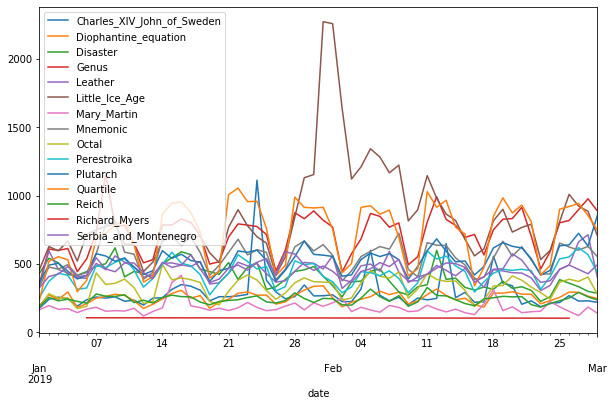

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df = joined.toPandas()
df.index = pd.to_datetime(df.date, format="%Y-%m-%d")
df.groupby("title")["count"].plot(legend=True, figsize=(10, 6))

## Example graph subgraph

In [67]:
from graphframes import GraphFrame
from pyspark.sql import functions as F

In [42]:
g = GraphFrame(pages, pagelinks.selectExpr("from as src", "dest as dst"))

In [43]:
g.inDegrees.show()

+--------+--------+
|      id|inDegree|
+--------+--------+
|44537799|     125|
|   65220|     954|
|43148707|     856|
|34909024|     571|
|17627213|   20485|
|45119513|      97|
|   40515|     600|
|55135231|     183|
|25896466|     366|
|21796920|     207|
|24870909|     351|
|37763802|      63|
|29714573|      62|
|  188834|    8469|
|37467237|      90|
|43437219|     597|
|  277404|     251|
|37767464|      59|
| 1730359|     252|
|  195642|     302|
+--------+--------+
only showing top 20 rows



In [49]:
seed = g.vertices.sample(False, 0.001).take(1)[0].id
seed

2732

In [53]:
# find all 2 hop neighbors to a random seed
paths = g.find("(a)-[e1]->(b); (b)-[e2]->(c)").where(f"a.id == {seed}")
paths.show()

+--------------------+----------------+--------------------+-----------------+--------------------+
|                   a|              e1|                   b|               e2|                   c|
+--------------------+----------------+--------------------+-----------------+--------------------+
|[2732, Au_file_fo...|   [2732, 53712]|[53712, Digital_a...|    [53712, 5300]|[5300, Computer_d...|
|[2732, Au_file_fo...|   [2732, 80733]|[80733, 32-bit, f...|    [80733, 5300]|[5300, Computer_d...|
|[2732, Au_file_fo...|   [2732, 46469]|[46469, Image_com...|    [46469, 5300]|[5300, Computer_d...|
|[2732, Au_file_fo...|[2732, 22525153]|[22525153, Dynami...| [22525153, 5300]|[5300, Computer_d...|
|[2732, Au_file_fo...|[2732, 11103036]|[11103036, Enhanc...| [11103036, 5300]|[5300, Computer_d...|
|[2732, Au_file_fo...|   [2732, 43026]|[43026, Endiannes...|    [43026, 5300]|[5300, Computer_d...|
|[2732, Au_file_fo...|    [2732, 6021]|[6021, C_(program...|     [6021, 5300]|[5300, Computer_d...|


In [55]:
edges = paths.select("e1.*").union(paths.select("e2.*"))
g2 = GraphFrame(g.vertices, edges)

In [60]:
g2.edges.cache()
g2.edges.count()

128206

In [64]:
g3 = g2.dropIsolatedVertices()
g3.vertices.count()

8954

In [68]:
g3.inDegrees.orderBy(F.desc("inDegree")).show()

+--------+--------+
|      id|inDegree|
+--------+--------+
|22163753|    1131|
|   63285|    1034|
|  237036|    1013|
| 5118708|     916|
| 1061675|     905|
|   20063|     889|
|  185636|     842|
| 7481030|     805|
| 1141367|     776|
|   20056|     776|
|43113036|     759|
|   14934|     754|
|    8013|     751|
|  694168|     702|
|   19673|     691|
| 6390226|     665|
|  218247|     661|
|   20060|     644|
|  161588|     640|
|31953149|     627|
+--------+--------+
only showing top 20 rows



In [69]:
results = g3.pageRank(resetProbability=0.15, tol=0.01)
results.vertices.select("id", "pagerank").show()
results.edges.select("src", "dst", "weight").show()

+-------+------------------+
|     id|          pagerank|
+-------+------------------+
|   7279|0.9637894932737353|
|  40634|0.9611946470973081|
|  42852|0.9624433955373168|
|  71575|0.9774730972863964|
|  92357|0.9685361027589254|
| 149593|0.9659365181896699|
| 194112|0.9630496183846331|
| 237036| 2.180348534891484|
| 342878|0.9606186393754486|
| 417534|0.9606186393754486|
| 477714|0.9619970458103446|
| 604896|0.9616253190133215|
| 685869|0.9697606151365787|
| 898503|0.9658640139911294|
|1040512|0.9619970458103446|
|1069091|0.9606186393754486|
|1348229| 0.980921956551414|
|1398166|0.9769431225299484|
|1627162|0.9660405571961082|
|1785141|1.0033475783285755|
+-------+------------------+
only showing top 20 rows

+----+----+--------------------+
| src| dst|              weight|
+----+----+--------------------+
|2732|2316|1.559989392072133...|
|2732|2316|1.559989392072133...|
|2732|2316|1.559989392072133...|
|2732|2316|1.559989392072133...|
|2732|2316|1.559989392072133...|
|2732|2316|1.5

In [72]:
results.vertices.where(f"id = {seed}").show()

+----+--------------+-----------+------+------------------+
|  id|         title|is_redirect|is_new|          pagerank|
+----+--------------+-----------+------+------------------+
|2732|Au_file_format|      false| false|2.0590215192214614|
+----+--------------+-----------+------+------------------+



In [73]:
results.vertices.select("title", "pagerank").orderBy(F.desc("pagerank")).show(truncate=False)

+----------------------------------------------+------------------+
|title                                         |pagerank          |
+----------------------------------------------+------------------+
|Data_compression                              |2.4264058291555077|
|MP3                                           |2.3417454755244758|
|Multimedia                                    |2.323895016698693 |
|FLAC                                          |2.28976530651448  |
|MPEG-2                                        |2.2479065293401663|
|International_Organization_for_Standardization|2.225186859055991 |
|International_Electrotechnical_Commission     |2.215192463874081 |
|Code-excited_linear_prediction                |2.2135587133501775|
|MPEG-1_Audio_Layer_II                         |2.2118718917168305|
|MPEG-1                                        |2.2025528881301404|
|High_Efficiency_Video_Coding                  |2.1990930771903114|
|Dolby_Digital                                 |

## Graph visualization

In [80]:
df = g3.edges.toPandas()
df[:10]

,src,dst
0,2732,53712
1,2732,80733
2,2732,46469
3,2732,22525153
4,2732,11103036
5,2732,43026
6,2732,6021
7,2732,29071
8,2732,26980
9,2732,80733


In [81]:
import networkx as nx

g4 = nx.from_pandas_edgelist(df, source="src", target="dst")

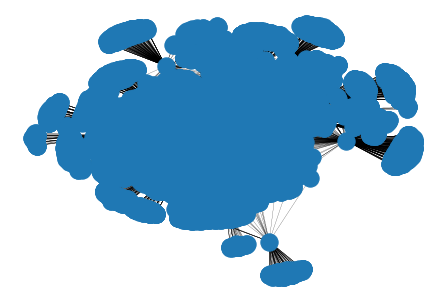

In [83]:
# too many nodes for this too look reasonable, use gephi instead?
nx.draw(g4, nodesize=5, width=0.2)